* [Data Details](https://www.iris.edu/hq/sis/insight#DMC)
* [IRIS API](https://service.iris.edu/fdsnws/dataselect/1/)

In [1]:
%config IPCompleter.greedy=True

import csv, json, os, sys
import requests
from time import sleep

In [2]:
# download data availability
#def download_data_availability(save_path='../data/mars/'):
def download_data_availability(save_path='eventdata/'):
    payload = {
        'option': 'com_ajax',
        'data': 'ELYSE',
        'format': 'json',
        'module': 'seis_data_available'
    }
    outfile = os.path.join(save_path, 'data_availability.json')
    if os.path.isfile(outfile):
        print(outfile+' already exists')
    else:
        r = requests.post('https://www.seis-insight.eu/en/science/seis-data/seis-data-availability', payload)
        with open(outfile, 'wb') as f:
            f.write(r.content)
        print(outfile+' written')


In [3]:
download_data_availability()

eventdata/data_availability.json already exists


In [4]:
def convertMetadataTextToCSV(save_path='eventdata/',infile='data_availability.json'):
    pinfile = os.path.join(save_path, infile)
    metadata = []
    headers = ['network','station','location','channel','quality','sample_rate','start','end']
    raw_line = open(pinfile, 'r').readline()

#    with open('eventdata/data_availability.json', 'r') as f:
#        for raw_line in f.readlines():
#            line = list(filter(lambda x: x != '', raw_line.split(' ')))
#            line = list(map(lambda x: x.strip('\n'), line))

    for oneline in raw_line.split('{')[2:]:
        jdict = {}
        for field in oneline[:-2].split(','):
            two = field.strip('"').split('":"')
            jdict[two[0]]= two[1]
       
        line = [
            jdict['network'],
            jdict['station'],
            jdict['location'],
            jdict['channel'],
            jdict['quality'],
            jdict['sampleRate'],
            jdict['startTime'][:17]+'00',
            jdict['endTime'][:17]+'00']   
        if line[2]=='00' or line[2]=='02':
            metadata.append(line)
    
    outfile = os.path.join(save_path, 'data_params.csv')
    with open(outfile, 'wt') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(headers) # write header
        for row in metadata:
            csv_writer.writerow(row)
            
    print(outfile+' written')

In [5]:
convertMetadataTextToCSV()

eventdata/data_params.csv written


In [15]:
def downloadSAC(save_path='eventdata/',infile='data_params.csv',line_offset=0, channel_filter=None, location_filter=None):
#    base = 'http://service.iris.edu/fdsnws/dataselect/1/query'
    base = 'http://service.iris.edu/irisws/timeseries/1/query'
    with open(os.path.join(save_path, infile), 'r') as f:
        for _ in range(line_offset):
            next(f)
        file_counter = line_offset+1
        for line in f.readlines():
            line = line.strip('\n').split(',')
            
            if channel_filter is not None:
                if line[3] not in channel_filter:
                    continue
            if location_filter is not None:
                if line[2] not in location_filter:
                    continue

            params = {
                'net': line[0],
                'sta': line[1],
                'loc': line[2],
                'cha': line[3],
                'start': line[6],
                'duration': '1800',
                'demean': 'true',
                'scale': 'auto',
                'format': 'sacbb'
            }
            r = requests.get(base, params=params)
            file_name = '_'.join([line[1], line[2], line[3], line[6].split(':')[0],line[6].split(':')[1] ])
            with open('../data/' + file_name + '.sac', 'wb') as c:
                c.write(r.content)
            
            sleep(1)
            file_counter += 1

In [16]:
# 20 Hz data, high gain:
locf=['02']
chanf=['BHU','BHV','BHW']
#100 Hz data, high gain
#locf=['00'],
#chanf=['HHU','HHV','HHW']

downloadSAC(
    infile='manual_params.csv',
    line_offset=0,
#    station_filter=['ELYSE'],
    channel_filter=chanf,
    location_filter=locf
)


In [17]:
from datetime import datetime
print(datetime.now())

2020-04-24 00:01:44.886902


In [34]:
from obspy import read
bhu = read('../data/ELYSE_02_BHU_2019-12-27T13_50.sac')
bhv = read('../data/ELYSE_02_BHV_2019-12-27T13_50.sac')
bhw = read('../data/ELYSE_02_BHW_2019-12-27T13_50.sac')

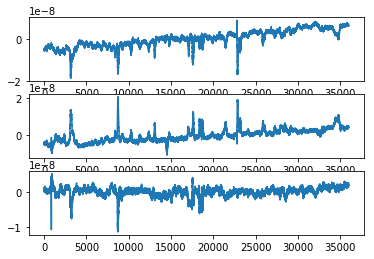

In [35]:
%matplotlib inline
import matplotlib.pyplot as pt 
pt.subplot(311)
pt.plot(bhu[0].data)
pt.subplot(312)
pt.plot(bhv[0].data)
pt.subplot(313)
pt.plot(bhw[0].data)
pt.show()



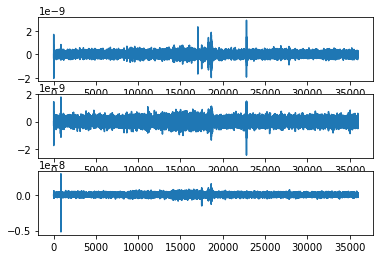

In [37]:
# code needs to be inserted here that removes the linear trend in the data plotted above - BEFORE filtering (bandpassing) the data (stream)

fu = bhu.filter('bandpass', freqmin=1.0, freqmax=5.0)
fv = bhv.filter('bandpass', freqmin=1.0, freqmax=5.0)
fw = bhw.filter('bandpass', freqmin=1.0, freqmax=5.0)
pt.subplot(311)
pt.plot(fu[0].data)
pt.subplot(312)
pt.plot(fv[0].data)
pt.subplot(313)
pt.plot(fw[0].data)
pt.show()

In [ ]:
# Download Catalog

# Standard BED format catalogue
# https://www.seis-insight.eu/static/mqs-catalogs/events_extended_preferredorigin_2019-10-01.xml
#!wget https://www.seis-insight.eu/static/mqs-catalogs/events_extended_preferredorigin_2019-10-01.xml -O data/events_extended_preferredorigin_2019-10-01.xml
    
# Mars-specific extension catalogue  
# https://www.seis-insight.eu/static/mqs-catalogs/events_extended_mars_preferredorigin_2019-10-01.xml
#!wget https://www.seis-insight.eu/static/mqs-catalogs/events_extended_mars_preferredorigin_2019-10-01.xml -O data/events_extended_mars_preferredorigin_2019-10-01.xml
    
    